In [16]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import Image, HTML 
from PIL import Image, ImageDraw

import sys
import os

#sys.path.append(os.path.join('D:/', 'Max', 'python', 'randimg'))
sys.path.append(os.getcwd())

import itertools
import ImgGenerator

tf.keras.backend.clear_session()  # For easy reset of notebook state.
# inputs = keras.Input(shape=(256, 50, 2)) # I have 40 picture for them 2 reduces each 256*50 size

interlaced_reduce_input = keras.Input(shape=( ImgGenerator.H, ImgGenerator.W//2, 2), name='interlaced_reduce')
print(interlaced_reduce_input.shape)
#small_conv = layers.DepthwiseConv2D(2, (2, 2), padding="same", activation='relu', data_format="channels_last", 
#                          name='small_conv')(interlaced_reduce_input) 
small_conv = layers.Conv2D(32, (2, 2), padding="same", activation='relu', data_format="channels_last", 
                          name='small_conv')(interlaced_reduce_input) 

small_conv = layers.LeakyReLU()(small_conv)
print(f'Small conv:{small_conv.shape}')
medium_conv = layers.Conv2D(64, (2, 2), padding="same", activation='relu', data_format="channels_last", 
                          name='medium_conv')(small_conv)
medium_conv = layers.LeakyReLU()(medium_conv)
print(f'Medium conv:{medium_conv.shape}')
large_conv = layers.Conv2D(128, (2, 2), padding="same", activation='relu', data_format="channels_last",
                          name='large_conv')(medium_conv)
#large_conv = medium_conv
large_conv = layers.LeakyReLU()(large_conv)
print(f'Large Conv2d:{large_conv.shape}')
#
def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = layers.UpSampling2D(size=2, data_format="channels_last")(layer_input)
    print(f"un-sample-shape:{u}")
    u = layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu', data_format="channels_last")(u)
    
    if dropout_rate:
        u = layers.Dropout(dropout_rate)(u)
    u = layers.BatchNormalization(momentum=0.8)(u)
    u = layers.Concatenate()([u, skip_input])
    return u
# Upsampling
#u1 = deconv2d(large_conv, medium_conv, 64)
#print(f"Deconv #1:{u1.shape}")
#u2 = deconv2d(u1, small_conv, 32)
#u3 = UpSampling2D(size=2)(u2)
#output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u3)
#u = layers.BatchNormalization(momentum=0.8)(large_conv)
#output_img = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u)
#o1 = layers.Reshape(target_shape=(128, 128 ))(o0)
u = layers.UpSampling2D(size=(1,2), data_format="channels_last")(large_conv)
u = layers.Dropout(.2)(u)
print(f"un-sample-shape:{u}")
output = u#layers.Dense(128)(u)
print(f"Out layer-1:{output.shape}")
output = layers.Dense(1, activation='relu')(output)
#output = layers.Reshape((128, 128))(output)
print(f"Out layer:{output.shape}")


(None, 128, 64, 2)
Small conv:(None, 128, 64, 32)
Medium conv:(None, 128, 64, 64)
Large Conv2d:(None, 128, 64, 128)
un-sample-shape:Tensor("dropout/Identity:0", shape=(None, 128, 128, 128), dtype=float32)
Out layer-1:(None, 128, 128, 128)
Out layer:(None, 128, 128, 1)


In [17]:
model = keras.Model(inputs=interlaced_reduce_input, outputs=output)
#model = keras.Model(inputs=x, outputs=output)
model.summary()
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
interlaced_reduce (InputLaye [(None, 128, 64, 2)]      0         
_________________________________________________________________
small_conv (Conv2D)          (None, 128, 64, 32)       288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 64, 32)       0         
_________________________________________________________________
medium_conv (Conv2D)         (None, 128, 64, 64)       8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 64, 64)       0         
_________________________________________________________________
large_conv (Conv2D)          (None, 128, 64, 128)      32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 64, 128)      0     

In [18]:

"""
#train_x = np.random.randint(0, high=10, size=(32, 128, 128, 1))
train_x = {"top_reduce": np.random.randint(0, high=10, size=(32, 128, 64, 1)),
           "left_reduce": np.random.randint(0, high=10, size=(32, 128, 64, 1))}
train_y = np.random.randint(0, high=1, size=(32, 128, 128, 1))
"""
N = 15
train_x, train_y = ([],[])
for x,y in itertools.islice( ImgGenerator.gen_numpy_2chanel_sample(), 0, N ):
    train_x.append(x) #train_x.append(np.expand_dims(x, 0))
    train_y.append(np.expand_dims(y, 2)) #train_y.append(y) #
train_x = np.stack(train_x)
train_y = np.stack(train_y)
print(f"Shape of train_x:{train_x.shape}, train_y:{train_y.shape}")
#print(f"Shape of train_x:{train_x[0].shape}, train_y:{train_y[0].shape}")

history = model.fit(train_x, train_y, epochs=N)


Shape of train_x:(15, 128, 64, 2), train_y:(15, 128, 128, 1)
Epoch 1/15
1/1 [==============================] - 0s 3ms/step - loss: 42744.6992 - mae: 167.7785
Epoch 2/15
1/1 [==============================] - 0s 3ms/step - loss: 42670.5742 - mae: 167.7020
Epoch 3/15
1/1 [==============================] - 0s 2ms/step - loss: 42590.7344 - mae: 167.6186
Epoch 4/15
1/1 [==============================] - 0s 2ms/step - loss: 42506.1602 - mae: 167.5296
Epoch 5/15
1/1 [==============================] - 0s 2ms/step - loss: 42412.9297 - mae: 167.4296
Epoch 6/15
1/1 [==============================] - 0s 2ms/step - loss: 42309.4102 - mae: 167.3178
Epoch 7/15
1/1 [==============================] - 0s 2ms/step - loss: 42192.9492 - mae: 167.1889
Epoch 8/15
1/1 [==============================] - 0s 2ms/step - loss: 42063.8398 - mae: 167.0397
Epoch 9/15
1/1 [==============================] - 0s 2ms/step - loss: 41919.2578 - mae: 166.8701
Epoch 10/15
1/1 [==============================] - 0s 2ms/step - l

In [19]:
#
# model evaluation
test_x = []
test_y = []

# make test set
for x, y in itertools.islice(ImgGenerator.gen_numpy_2chanel_sample(), 0, N):
    test_x.append(x)
    test_y.append(np.expand_dims(y, 2))

test_x = np.stack(test_x)
test_y = np.stack(test_y) # convert from list to np.array

print(f'Test: x-shape:{test_x.shape}, y-shape:{test_y.shape}')

test_scores = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


Test: x-shape:(15, 128, 64, 2), y-shape:(15, 128, 128, 1)
1/1 - 0s - loss: 40146.4258 - mae: 163.3027
Test loss: 40146.42578125
Test accuracy: 163.302734375


In [22]:
#target_y, predict_in = zip(
#    *[(y, x) for x, y in itertools.islice(ImgGenerator.gen_numpy_2chanel_sample(), 0,4)] )
print(test_x.shape)
#predict_in = np.stack(predict_in)
predict_in = test_x
prediction = model.predict(predict_in)
print(prediction.shape)

(15, 128, 64, 2)
(15, 128, 128, 1)


(128, 128, 1)
(128, 128)


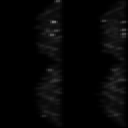

In [23]:
print(prediction[0].shape)
#print(prediction[0].astype(np.uint8)[0,:,:])
#v = prediction[0].astype(np.uint8)[:,:,0]
v = prediction[0].astype(np.uint8).reshape((128,128))
print(v.shape)
#iv = Image.fromarray(prediction[0], 'RGB')
iv = Image.fromarray(v, 'L')
display(iv)

(15, 128, 128, 1)


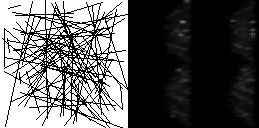

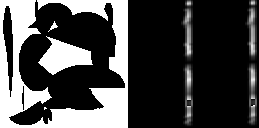

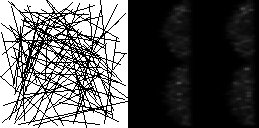

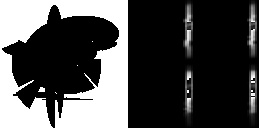

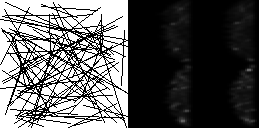

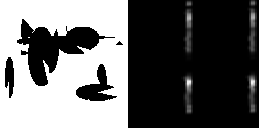

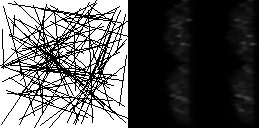

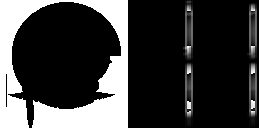

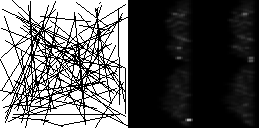

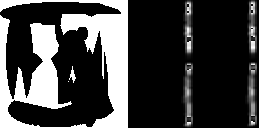

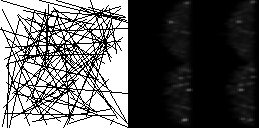

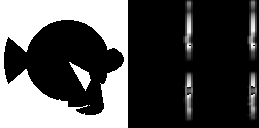

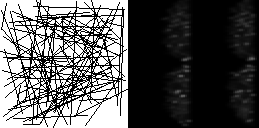

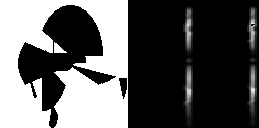

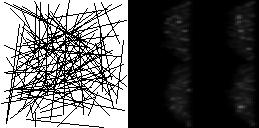

In [27]:
print(test_y.shape)
# ix = Image.fromarray((target_y[0]*255).astype(np.int8), 'L') 

for v, y in zip(prediction, test_y):
    iy = Image.fromarray(y[:,:,0], 'L')
    #av = v.astype(np.uint8)[:,:,0]
    av = v.astype(np.uint8).reshape((ImgGenerator.H,ImgGenerator.W))
    ix = Image.fromarray(av, 'L')
    
    tub = Image.new("RGB", (ImgGenerator.W*2 + 3, ImgGenerator.H))
    tub.paste(iy, (0, 0, ImgGenerator.W, ImgGenerator.H))
    tub.paste(ix, (ImgGenerator.W+1, 0))
    display(tub)
        

In [1]:
av = v1[0,:,:]
print(av)
av = av >0.7
iy = Image.fromarray((av.astype(np.int)*255).astype(np.int8), 'L')
display(iy)

NameError: name 'v1' is not defined